In [24]:
from __future__ import print_function
from __future__ import division

from collections import OrderedDict
import os
import sys
import warnings

import argparse
import logging
import h5py as h5
import numpy as np
import pandas as pd
import scipy.io

import six
from six.moves import range
import csv
import math as ma
from sklearn.metrics import roc_auc_score, confusion_matrix, average_precision_score,roc_curve,auc,precision_recall_curve
from keras.preprocessing import sequence
from keras.optimizers import RMSprop,Adam, Adadelta, Nadam, Adamax, SGD, Adagrad
from keras.models import Sequential
from keras.layers.core import  Dropout, Activation, Flatten
from keras.regularizers import l1,l2,l1_l2
from keras.constraints import maxnorm
#from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Conv1D, MaxPooling1D, Dense, LSTM, Bidirectional
import matplotlib.pyplot as plt

In [25]:
h5filename = "histonemodTF_resample_ncl_Cells.h5"
h5file = h5.File(h5filename,'r')
input_features = h5file['input/H1_H3K27ac_RPKM']
output = h5file['output/H1_H3K27ac']
train_x = np.array(input_features)
train_y = np.array(output, dtype = 'int8')
print(train_x.shape)
print(train_y.shape)   

(25259, 17)
(25259,)


In [26]:
input_features = h5file['input/GM12878_H3K27ac_RPKM']
output = h5file['output/GM12878_H3K27ac']
input_features = np.array(input_features)
output = np.array(output)
output_reshape = output.reshape(len(output),1)
print(input_features.shape)

(25826, 17)


In [27]:
#combine the label with input dna
input_features_label = np.concatenate((input_features,output_reshape), axis=1)
df = pd.DataFrame(output)
pos_label= df.loc[df.iloc[:,0]==1]
pos_label_ix = np.array(pos_label.index)
neg_label = df.loc[df.iloc[:,0]==0]
neg_label_ix = np.array(neg_label.index)
pos_sam = input_features_label[pos_label_ix,:]
neg_sam = input_features_label[neg_label_ix,:]
np.random.shuffle(pos_sam)
np.random.shuffle(neg_sam)
print(pos_sam.shape)
print(neg_sam.shape)

(7826, 18)
(18000, 18)


In [28]:
val_neg_sample = int(ma.ceil(neg_sam.shape[0] *0.2))
val_pos_sample = int(ma.ceil(pos_sam.shape[0] *0.2))
val_neg = neg_sam[0:val_neg_sample,:]
val_pos = pos_sam[0:val_pos_sample,:]
val_neg_pos = np.concatenate((val_neg, val_pos),axis = 0)
val_x = val_neg_pos[:,0:17]
val_y = val_neg_pos[:,17]
val_x = np.array(val_x)
val_y = np.array(val_y, dtype='int8')
frq = np.bincount(val_y)
print(frq)

[3600 1566]


In [29]:
test_neg_sample = neg_sam[val_neg_sample:,:]
test_pos_sample = pos_sam[val_pos_sample:,:]
test_neg_pos = np.concatenate((test_neg_sample, test_pos_sample),axis = 0)
test_x = test_neg_pos[:,0:17]
test_y = test_neg_pos[:,17]
test_y = np.array(test_y, dtype='int8')
frq = np.bincount(test_y)
print(frq)

[14400  6260]


In [30]:
model = Sequential()
model.add(Dense(units=256, input_dim=17, activation="relu",kernel_initializer='glorot_uniform'))
model.add(Dropout(0.3))
model.add(Dense(units=180,  activation="relu",kernel_initializer='glorot_uniform'))
model.add(Dropout(0.3))
model.add(Dense(units= 60, activation="relu",kernel_initializer='glorot_uniform')) 
model.add(Dense(units=1,  activation="sigmoid")) 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               4608      
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 180)               46260     
_________________________________________________________________
dropout_6 (Dropout)          (None, 180)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 60)                10860     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 61        
Total params: 61,789
Trainable params: 61,789
Non-trainable params: 0
_________________________________________________________________


In [31]:
adam = Adam(lr = 0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="HistoneMark_H3K4me3_TF_cells.hdf5",verbose=1, monitor='val_loss',save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model.fit(train_x, train_y, batch_size=10, epochs=90, shuffle=True, validation_data=(val_x, val_y), callbacks=[checkpointer,earlystopper])
y_pred = model.predict(test_x)
#np.savetxt('H1_K562_H3K4me3_true.csv', test_y, delimiter=",")
tresults = model.evaluate(test_x, test_y)
print(tresults)
print(roc_auc_score(test_y, y_pred))
print(average_precision_score(test_y, y_pred))


Train on 25259 samples, validate on 5166 samples
Epoch 1/90
25160/25259 [============================>.] - ETA: 0s - loss: 0.2991 - acc: 0.8959
Epoch 00001: val_loss improved from inf to 1.01596, saving model to HistoneMark_H3K4me3_TF_cells.hdf5
25259/25259 [==============================] - 8s 307us/step - loss: 0.2985 - acc: 0.8962 - val_loss: 1.0160 - val_acc: 0.7257
Epoch 2/90
25110/25259 [============================>.] - ETA: 0s - loss: 0.2143 - acc: 0.9153
Epoch 00002: val_loss improved from 1.01596 to 0.94281, saving model to HistoneMark_H3K4me3_TF_cells.hdf5
25259/25259 [==============================] - 7s 284us/step - loss: 0.2144 - acc: 0.9153 - val_loss: 0.9428 - val_acc: 0.7249
Epoch 3/90
25230/25259 [============================>.] - ETA: 0s - loss: 0.2004 - acc: 0.9174
Epoch 00003: val_loss improved from 0.94281 to 0.81091, saving model to HistoneMark_H3K4me3_TF_cells.hdf5
25259/25259 [==============================] - 7s 283us/step - loss: 0.2002 - acc: 0.9175 - val_lo

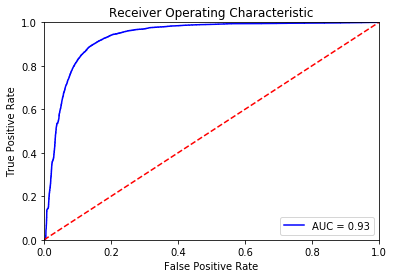

In [32]:
fpr, tpr, threshold = roc_curve(test_y, y_pred)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


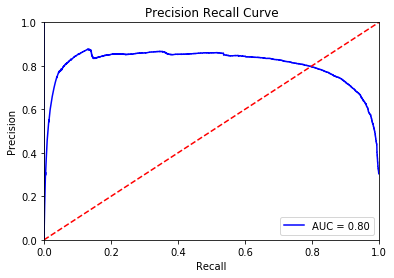

[[14163   237]
 [ 4862  1398]]


In [33]:
precision, recall, thresholds = precision_recall_curve(test_y, y_pred)
pr_auc = average_precision_score(test_y, y_pred)
plt.title('Precision Recall Curve')
plt.plot(recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()
y_pred = (y_pred>0.5)
cm = confusion_matrix(test_y, y_pred)
print(cm)

In [34]:
h5file.close()

In [11]:
np.savetxt('H1_K562_H3K4me3_true.csv', test_y, delimiter=",")
np.savetxt('H1_K562_H3K4me3_pred.csv', y_pred, delimiter=",")

In [12]:
np.savetxt('H1_K562_H3K4me3_true_x.csv', test_x, delimiter=",")